

```
# Código Exemplo: Autoencoders
# Adaptado de https://blog.keras.io/building-autoencoders-in-keras.html
```



Autoencoder: Versão mais simples possível!

In [1]:
import keras
from keras import layers


In [2]:
# from keras import regularizers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


In [ ]:

# This is our input image
input_img = keras.Input(shape=(784,))

# 'encoded' is the encoded representation of the input.
# Para uma representação menos sucetível a overfitting e ruído, adicione regularização l1
# A regularização l1 confere mais esparsidade (seleção interna de atributos) com o parâmetro:  activity_regularizer=regularizers.l1(10e-5)
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)

# 'decoded' is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [13]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [14]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [15]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_8 (Dense)             (None, 32)                25120     
                                                                 
 dense_9 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [32]:
import keras
from keras.models import Sequential

def autoencoder_create(parameters: dict):
    
    model = Sequential()
    model.add(keras.Input(shape=(784,)))

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=parameters['dim'][-1-i],
                               activation=parameters['activation']
                               ))

    model.add(layers.Dense(units=parameters['dim'][0],
                           activation=parameters['activation']
                           ))

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=parameters['dim'][i-parameters['intermediate']],
                               activation=parameters['activation']
                               ))

    model.add(layers.Dense(units=784, activation=parameters['out_activation']))
    
    return model

In [17]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def train_mlp(model: keras.Model,
              train_params: dict,
              train_dataset: tuple,
              val_dataset: tuple,
              ):
    
    optimizer = Adam(learning_rate=train_params['learning_rate'],
                     #weight_decay=train_params['weight_decay'],
                     decay=train_params['decay'],
                     )
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  #loss='MeanSquaredError',
                  metrics=['RootMeanSquaredError'],
                  )

    early = EarlyStopping(monitor='val_loss',
                          mode='min',
                          patience=train_params['early_stop_patience'],
                          restore_best_weights=True,
                          )
    
    callback_list = [early]

    hist = model.fit(x=train_dataset[0],
                     y=train_dataset[1],
                     epochs=train_params['num_epochs'],
                     validation_data=val_dataset,
                     callbacks=callback_list,
                     )
    
    return model, hist

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [7]:
x_train = x_train.astype('float32') / 255.
#x_train = x_train.astype('float32')
x_test = x_test.astype('float32') / 255.
#x_test = x_test.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [28]:
autoencoder = autoencoder_create([784/32, 784/8], 1)
autoencoder.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  #loss='MeanSquaredError'(name='mse'),
                  metrics=['RootMeanSquaredError']
                  )

In [29]:
print(autoencoder.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 98)                76930     
                                                                 
 dense_21 (Dense)            (None, 24)                2376      
                                                                 
 dense_22 (Dense)            (None, 98)                2450      
                                                                 
 dense_23 (Dense)            (None, 784)               77616     
                                                                 
Total params: 159,372
Trainable params: 159,372
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = autoencoder.fit(x=x_train,
                          y=x_train,
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

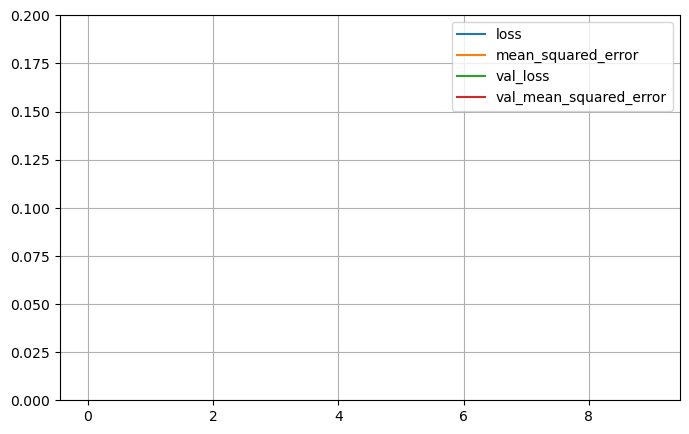

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.2)
plt.show()

In [10]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = autoencoder.predict(x_test)
#decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 2ms/step


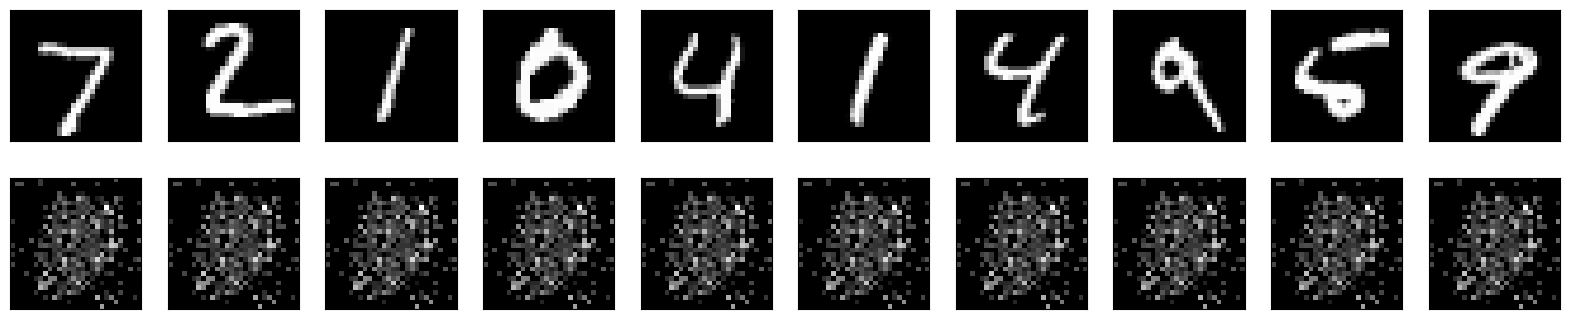

In [11]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()